In [87]:
import pandas as pd
import numpy as np
from typing import List, Tuple
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import RegressorMixin
import pickle

Model = GradientBoostingRegressor

LEAR_DATA_FILE = 'learn_data.csv'
MODEL_STATE_PATH = 'model.pkl'

FEATURE = ['func_tr', 'dif']
Y = 'duration'

# Build learn data

вариант №3

In [ ]:
name_mapping = {
    'func_tr': 'Функциональных требования',
    'dif': 'Сложность тестов',
    'duration': 'Часы тестирования',
}

def with_read_cols(data: pd.DataFrame):
    data = data.copy().rename(columns=name_mapping)

    return data


data = [
    {'index': 0, 'func_tr': 10, 'dif': 3, 'duration': 30},
    {'index': 1, 'func_tr': 20, 'dif': 4, 'duration': 50},
    {'index': 2, 'func_tr': 15, 'dif': 5, 'duration': 60},
    {'index': 3, 'func_tr': 25, 'dif': 2, 'duration': 40},
    {'index': 4, 'func_tr': 30, 'dif': 6, 'duration': 70},
]

df = pd.DataFrame.from_records(data)
df.set_index('index')
df.to_csv(LEAR_DATA_FILE, index=False)
with_read_cols(df)

,index,Функциональных требования,Сложность тестов,Часы тестирования
0,0,10,3,30
1,1,20,4,50
2,2,15,5,60
3,3,25,2,40
4,4,30,6,70


## Load learn data

In [69]:
learn_df = pd.read_csv(LEAR_DATA_FILE)
learn_df.set_index('index')
with_read_cols(learn_df)

,index,Функциональных требования,Сложность тестов,Часы тестирования
0,0,10,3,30
1,1,20,4,50
2,2,15,5,60
3,3,25,2,40
4,4,30,6,70


## Visualize data dep

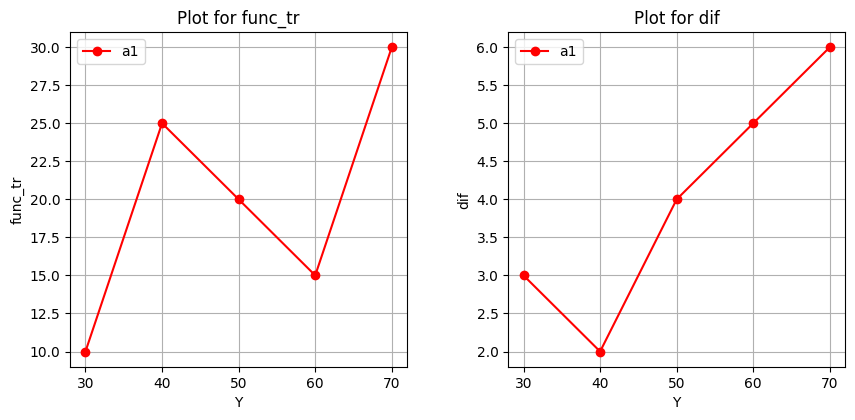

In [70]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots_adjust

def get_values_xy_for(feature: str) -> List[Tuple[int, int]]:
    result = []
    # print(learn_df.sort_values(feature, axis=0)[feature])
    for _, row in learn_df.sort_values(Y, axis=0).iterrows():
        x = row[feature]
        y = row[Y]

        result.append((x, y))

    return result

fig = plt.figure(num=1, facecolor='w', edgecolor='k')
fig.set_figwidth(10)
fig.set_figheight(10)
subplots_adjust(hspace=0.3, wspace=0.3)


for index, feature in enumerate(FEATURE):
    data = get_values_xy_for(feature=feature)
    yy = list(map(lambda x: x[0], data))
    xx = list(map(lambda x: x[1], data))

    ax = fig.add_subplot(2, 2, index + 1)
    ax.plot(xx, yy, color='red', label=f'a1', linestyle='solid', marker='o')
    ax.set_title(f'Plot for {feature}')
    ax.set_ylabel(f'{feature}')
    ax.set_xlabel('Y')
    ax.grid()
    ax.legend()

plt.show()



## Learn linear boost ans model

In [89]:
from sklearn.metrics import mean_squared_error

test_df = learn_df.copy()

X = learn_df[FEATURE]
y = learn_df[Y]

model = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.01,
    n_estimators=500,
    criterion='friedman_mse',
    max_depth=5,
    min_samples_split=5,
)

model.fit(X, y)

print(f"Model score: {model.score(X, y)}")

model_predict = model.predict(test_df[FEATURE])
print(f"Mean square error: {mean_squared_error(test_df[Y], model_predict)}")

with open(MODEL_STATE_PATH,'wb') as file:
    pickle.dump(model, file)

Model score: 0.9977899738186594
Mean square error: 0.4420052362681172


## Learn linear model

In [ ]:
from sklearn.metrics import mean_squared_error

test_df = learn_df.copy()

X = learn_df[FEATURE]
y = learn_df[Y]

model = LinearRegression(
    copy_X=True,
)

model.fit(X, y)

print(f"Model score: {model.score(X, y)}")
print(f"Model coef: {model.coef_}")
print(f"Model base: {model.intercept_}")

model_predict = model.predict(test_df[FEATURE])
print(f"Mean square error: {mean_squared_error(test_df[Y], model_predict)}")

with open(MODEL_STATE_PATH,'wb') as file:
    pickle.dump(model, file)

Model score: 0.9296703296703297
Model coef: [0.72527473 7.91208791]
Model base: 3.8461538461538183
Mean square error: 14.06593406593407


## Test model

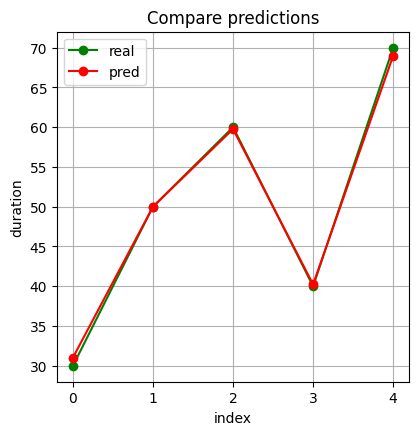

In [90]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots_adjust

work_df = learn_df.copy()

with open(MODEL_STATE_PATH, 'rb') as f:
    model: Model = pickle.load(f)


predictions = model.predict(work_df[FEATURE])

show_df = work_df.copy()
show_df[f"{Y}_pred"] = predictions

fig = plt.figure(num=1, facecolor='w', edgecolor='k')
fig.set_figwidth(10)
fig.set_figheight(10)

x = list(show_df.index)
y1 = show_df[Y]
y2 = show_df[f"{Y}_pred"]

ax = fig.add_subplot(2, 2, 1)
ax.plot(x, y1, color='green', label=f'real', marker='o', linestyle='-')
ax.plot(x, y2, color='red', label=f'pred', marker='o', linestyle='-')

ax.set_title(f'Compare predictions')
ax.set_xlabel('index')
ax.set_ylabel(f'{Y}')
ax.grid()
ax.legend()

